In [1]:
from LRL import *

## Environment

In [2]:
import gym

Для использования $V$-функции вместо $Q$-функции понадобилась необходимость "в торче" искать все возможные следующие состояния для батча кубиков, поэтому пришлось писать вспомогательный класс:

In [3]:
class BatchOfRubiks:
    def __init__(self, groups):
        self.group = groups
        
    def forward_cycle(self, a, b, c, d):
        self.group[:, a-1], self.group[:, b-1], self.group[:, c-1], self.group[:, d-1] = \
        self.group[:, d-1].clone(), self.group[:, a-1].clone(), self.group[:, b-1].clone(), self.group[:, c-1].clone()
        return self
    
    def backward_cycle(self, a, b, c, d):
        self.group[:, a-1], self.group[:, b-1], self.group[:, c-1], self.group[:, d-1] = \
        self.group[:, b-1].clone(), self.group[:, c-1].clone(), self.group[:, d-1].clone(), self.group[:, a-1].clone()
        return self

    def rotate(self, command):
        self.cycle = self.forward_cycle if command < 6 else self.backward_cycle
        command = command % 6
        
        if command == 0:
            self.cycle(1,3,8,6).cycle(2,5,7,4).cycle(33,9,41,32).cycle(36,12,44,29).cycle(38,14,46,27)
        elif command == 1:
            self.cycle(9,11,16,14).cycle(10,13,15,12).cycle(38,17,43,8).cycle(39,20,42,5).cycle(40,22,41,3)
        elif command == 2:
            self.cycle(17,19,24,22).cycle(18,21,23,20).cycle(48,16,40,25).cycle(45,13,37,28).cycle(43,11,35,30)
        elif command == 3:
            self.cycle(25,27,32,30).cycle(26,29,31,28).cycle(19,33,6,48).cycle(21,34,4,47).cycle(24,35,1,46)
        elif command == 4:
            self.cycle(33,35,40,38).cycle(34,37,39,36).cycle(25,17,9,1).cycle(26,18,10,2).cycle(27,19,11,3)
        elif command == 5:
            self.cycle(41,43,48,46).cycle(42,45,47,44).cycle(6,14,22,30).cycle(7,15,23,31).cycle(8,16,24,32)
        return self

def next_states(states):
    ns = torch.cat([BatchOfRubiks(states.clone()).rotate(i).group[:, None] for i in range(12)], dim=1)
    done = ((ns != Tensor([0]*8 + [1]*8 + [2]*8 + [3]*8 + [4]*8 + [5]*8)).sum(dim=2) > 0).type(torch.cuda.FloatTensor)
    return ns, Tensor(states.size()[0], 12).zero_() - 1, 1 - done

Сама среда. Награда: -1 всегда.
* complexity: сколько раз к собранному кубику применяется рандомное действие при ресете.
* limit: после такого числа ходов агент "умирает", однако при обучении флаг done агенту НЕ выдаётся, так как это не конечное состояние "на самом деле".

In [4]:
class Rubik:
    def __init__(self, complexity=1, limit=50):
        self.complexity = complexity
        self.limit = limit
        self.action_space = gym.spaces.Discrete(12)
        self.init_state = [0]*8 + [1]*8 + [2]*8 + [3]*8 + [4]*8 + [5]*8
        self.steps = 0
        self.next_states_function = next_states
        self.reset()
    
    def reset(self):
        self.group = self.init_state[:]
        
        while self.group == self.init_state:
            for _ in range(self.complexity):
                self.step(np.random.randint(0, 12))
        
        self.steps = 0
        return self.group
    
    def forward_cycle(self, a, b, c, d):
        self.group[a-1], self.group[b-1], self.group[c-1], self.group[d-1] = self.group[d-1], self.group[a-1], self.group[b-1], self.group[c-1]
        return self
    
    def backward_cycle(self, a, b, c, d):
        self.group[a-1], self.group[b-1], self.group[c-1], self.group[d-1] = self.group[b-1], self.group[c-1], self.group[d-1], self.group[a-1]
        return self
        
    def rotate(self, command):
        # решения через циклические сдвиги в двумерном массиве без нумпая привели к экспоненциальному росту костылей в коде.
        # кажется, это наиболее лаконичный и бескровный вариант
        if command == 0:
            self.cycle(1,3,8,6).cycle(2,5,7,4).cycle(33,9,41,32).cycle(36,12,44,29).cycle(38,14,46,27)
        elif command == 1:
            self.cycle(9,11,16,14).cycle(10,13,15,12).cycle(38,17,43,8).cycle(39,20,42,5).cycle(40,22,41,3)
        elif command == 2:
            self.cycle(17,19,24,22).cycle(18,21,23,20).cycle(48,16,40,25).cycle(45,13,37,28).cycle(43,11,35,30)
        elif command == 3:
            self.cycle(25,27,32,30).cycle(26,29,31,28).cycle(19,33,6,48).cycle(21,34,4,47).cycle(24,35,1,46)
        elif command == 4:
            self.cycle(33,35,40,38).cycle(34,37,39,36).cycle(25,17,9,1).cycle(26,18,10,2).cycle(27,19,11,3)
        elif command == 5:
            self.cycle(41,43,48,46).cycle(42,45,47,44).cycle(6,14,22,30).cycle(7,15,23,31).cycle(8,16,24,32)
    
    def step(self, command):
        self.cycle = self.forward_cycle if command < 6 else self.backward_cycle
        self.rotate(command % 6)
        
        self.steps += 1        
        done = self.group == self.init_state
        died = self.steps > self.limit
        return self.group, -1, done, {"died": died}
                
    def __str__(self):
        return '.'*3 + ''.join(map(str, self.group[32:35])) + '.'*6 + '\n' +\
               '.'*3 + str(self.group[35]) + 'U' + str(self.group[36]) + '.'*6 + '\n' +\
               '.'*3 + ''.join(map(str, self.group[37:40])) + '.'*6 + '\n' +\
               ''.join(map(str, self.group[0:3] + self.group[8:11] + self.group[16:19] + self.group[24:27])) + '\n' +\
               str(self.group[3]) + 'L' + str(self.group[4]) + str(self.group[11]) + 'F' + str(self.group[12]) + str(self.group[19]) + 'R' + str(self.group[20]) + str(self.group[27]) + 'B' + str(self.group[28]) + '\n' +\
               ''.join(map(str, self.group[5:8] + self.group[13:16] + self.group[21:24] + self.group[29:32])) + '\n' +\
               '.'*3 + ''.join(map(str, self.group[40:43])) + '.'*6 + '\n' +\
               '.'*3 + str(self.group[43]) + 'D' + str(self.group[44]) + '.'*6 + '\n' +\
               '.'*3 + ''.join(map(str, self.group[45:48])) + '.'*6 + '\n'

In [5]:
rubik = Rubik()

c:\windows\system32\gym\gym\__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [6]:
print(rubik)

...000......
...4U4......
...444......
500111224333
5L01F12R43B3
500111224333
...555......
...5D5......
...222......



# Сеть

Возможная причина проблем --- неадекватность модели. Простая полносвязная сеть не очень видит кучу нетривиальных инвариантов, творящихся в данных, тем более зашумлённых. Было решено найти все 24 инварианта текущей конфигурации кубика. Для этого кровью и потом был вычислен тензор 24 х 48, получающий все конфигурации

In [7]:
INVARIANTS = Tensor(np.load("RubikInvariantsMatrix.npy"))
INVARIANTS.shape

torch.Size([24, 48, 48])

А one_hot кодировки для 6 цветов не оказалось в дефолтных функций пайторча.

In [8]:
def one_hot(x, nb_digits):
    x_onehot = Tensor(x.size()[0]*x.size()[1], nb_digits)
    x_onehot.zero_()
    x_onehot.scatter_(1, x.view(-1, 1).type(torch.cuda.LongTensor), 1)
    return x_onehot.view(x.size()[0], x.size()[1], nb_digits)

Сама сеть. Для каждой конфигурации выдаём 100 фич. По конфигурациям из этих фич берём максимум, дальше небольшой полносвязник. "Крышка" (выдающая всего одно число - value состояния) будет добавлена моей библиотечечкой LRL.

In [42]:
class ValueNet(nn.Module):
    def __init__(self, linear):
        super(ValueNet, self).__init__()
        
        self.invariantial = nn.Sequential(
            nn.Linear(48*6, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            linear(100, 120),
            nn.ReLU(),
            linear(120, 80),
            nn.ReLU()
        )

    def forward(self, x):
        x = INVARIANTS.matmul(x.transpose(0, 1)).permute(2, 0, 1).contiguous().view(-1, 48)
        x = one_hot(x, 6).view(-1, 48*6)
        x = self.invariantial(x).view(-1, 24, 100)
        x = x.max(dim=1)[0]
        return self.fc(x)

# Agent

In [81]:
def VAgent(parclass):
    """Requires parent class, inherited from Agent."""

    class VAgent(parclass):
        __doc__ += parclass.__doc__
        
        def get_loss(self, y, guess):
            return F.smooth_l1_loss(guess, y, reduction="none")

        def optimize_model(self):
            '''One step of Q-network optimization'''
            if len(self) < self.replay_buffer_init:
                return

            state_b, action_b, reward_b, next_state_b, done_b, weights_b = self.sample(self.batch_size)

            state_b      = Tensor(np.float32(state_b))
            next_state_b = Tensor(np.float32(next_state_b))
            action_b     = LongTensor(action_b)
            reward_b     = Tensor(reward_b)
            done_b       = Tensor(done_b)
            weights_b    = Tensor(weights_b)

            self.policy_net.train()
            q_values      = self.policy_net.gather(self.policy_net(state_b), action_b)
            with torch.no_grad():
                target_q_values = self.batch_target(reward_b, next_state_b, done_b)
            
            #with torch.no_grad():
            #    values_of_state_target = self.estimate_next_state(state_b) - 1
            #values = self.policy_net.head(self.policy_net.feature_extractor_net(state_b)).squeeze(1)
            
            loss_b = self.get_loss(target_q_values, q_values)
            #loss_b = loss_b + self.get_loss(values_of_state_target, values)
            self.update_priorities(self.get_transition_importance(loss_b).detach().cpu().numpy())

            loss = (loss_b * weights_b).mean()
            self.loss_log.append(loss.detach().cpu().numpy())

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    return VAgent

In [98]:
agent = VAgent(DoubleQAgent(QAgent(NstepReplay(ReplayBufferAgent))))(env=rubik,
                FeatureExtractorNet = ValueNet, 
                features_size =80, 
                QnetworkHead = Vnetwork,
                noisy = False,
                target_update = 100,
                batch_size=32, 
                gamma=1,
                replay_buffer_nsteps = 1,
                replay_buffer_init=100,
                replay_buffer_capacity=10000,
                #rp_alpha=0.6, rp_beta_start = 0.5, rp_beta_frames = 3000,
                #epsilon_start = 1.0, epsilon_final = 0.01, epsilon_decay = 100,
                optimizer_args={"lr": 0.001})

In [99]:
rubik.complexity, rubik.limit = 1, 3

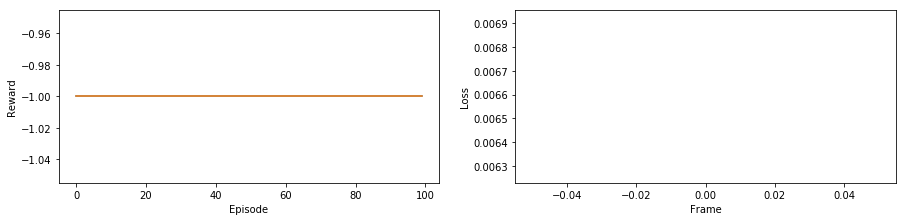







100%|████████████████████████████████████████| 100/100 [00:22<00:00,  4.45it/s]







Complete


In [100]:
from tqdm import tqdm
for i in tqdm(range(100)):
    agent.play()
    plot_durations(agent, 20)

print('Complete')
plt.show()

### Проверка адекватности

In [136]:
s = rubik.reset()
agent.policy_net(Tensor(s)[None])

tensor([[-6.7455, -4.1815, -7.9893, -6.6507, -7.0629, -4.8828, -5.5282, -4.0200,
         -7.2350, -4.1948, -4.2414, -3.4259]],
       device='cuda:0', grad_fn=<ThAddBackward>)

In [102]:
next_states(Tensor(s)[None])

(tensor([[[0., 0., 1., 0., 1., 0., 0., 1., 4., 2., 2., 4., 1., 4., 1., 1., 3.,
           3., 3., 2., 2., 2., 2., 2., 0., 0., 5., 3., 5., 3., 3., 5., 3., 4.,
           4., 3., 4., 0., 4., 4., 2., 5., 5., 1., 5., 1., 5., 5.],
          [1., 1., 5., 0., 5., 0., 0., 5., 1., 1., 2., 1., 2., 1., 1., 2., 4.,
           3., 3., 4., 2., 4., 2., 2., 0., 0., 0., 3., 3., 3., 3., 3., 4., 4.,
           4., 4., 4., 0., 0., 1., 2., 2., 3., 5., 5., 5., 5., 5.],
          [1., 1., 1., 0., 0., 0., 0., 0., 2., 2., 5., 1., 5., 1., 1., 5., 2.,
           2., 3., 2., 3., 2., 2., 3., 4., 0., 0., 4., 3., 4., 3., 3., 4., 4.,
           2., 4., 1., 4., 4., 1., 5., 5., 3., 5., 3., 5., 5., 0.],
          [4., 1., 1., 4., 0., 4., 0., 0., 2., 2., 2., 1., 1., 1., 1., 1., 3.,
           3., 5., 2., 5., 2., 2., 5., 3., 3., 0., 3., 0., 3., 3., 0., 3., 2.,
           2., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 1., 0., 0.],
          [2., 2., 2., 0., 0., 0., 0., 0., 3., 3., 3., 1., 1., 1., 1., 1., 0.,
           0., 0.

Попробуем стирать буфер памяти (обнуление frames_done нужно для буфера с приоритетами

In [103]:
def reset(agent):
    agent.buffer = []
    agent.pos = 0
    agent.priorities = []
    agent.frames_done = 0

## Уровень 2

In [104]:
rubik.complexity, rubik.limit = 2, 4

In [105]:
reset(agent)

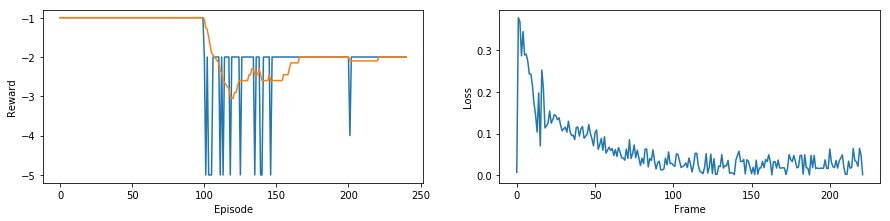

Percentage of success:  0.99
Complete


In [106]:
for i in tqdm(range(1000)):
    agent.play()
    plot_durations(agent, 20)
    
    res = (np.array(agent.rewards_log[-100:]) > -5).mean()
    print("Percentage of success: ", res)
    if i > 100 and res > 0.98:
        break

print('Complete')
plt.show()

# Уровень 3

In [108]:
reset(agent)
agent.replay_buffer_nsteps = 2   # повысило с 0.9 до 0.96!!!!

In [109]:
rubik.complexity, rubik.limit = 3, 6

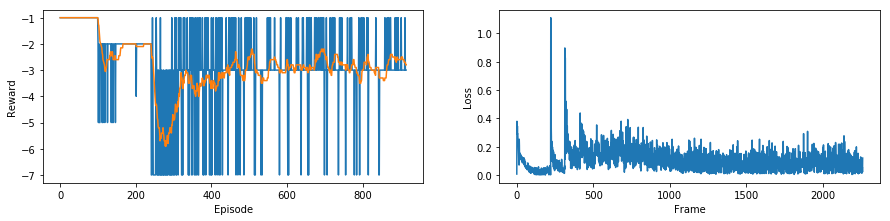

Percentage of success:  0.98
Complete


In [110]:
for i in tqdm(range(1000)):
    agent.play()
    plot_durations(agent, 20)
    
    res = (np.array(agent.rewards_log[-100:]) > -7).mean()
    print("Percentage of success: ", res)
    if i > 100 and res > 0.97:
        break

print('Complete')
plt.show()

In [111]:
#agent.save("DQN 2-step level 3")

# Уровень 4

In [114]:
reset(agent)

In [135]:
rubik.complexity, rubik.limit = 4, 8

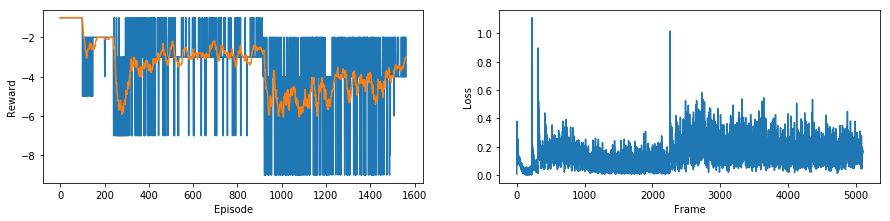

Percentage of success:  0.97
Complete


In [116]:
for i in tqdm(range(1000)):
    agent.play()
    plot_durations(agent, 20)
    
    res = (np.array(agent.rewards_log[-100:]) > -9).mean()
    print("Percentage of success: ", res)
    if i > 100 and res > 0.96:
        break

print('Complete')
plt.show()

In [117]:
agent.save("DQN 2-step level 4")

# Уровень 5

In [137]:
agent.load("DQN 2-step level 4")

In [138]:
reset(agent)

In [140]:
agent.replay_buffer_nsteps = 2
agent.optimizer = torch.optim.Adam(agent.policy_net.parameters(), lr=0.0035)

In [141]:
rubik.complexity, rubik.limit = 5, 10

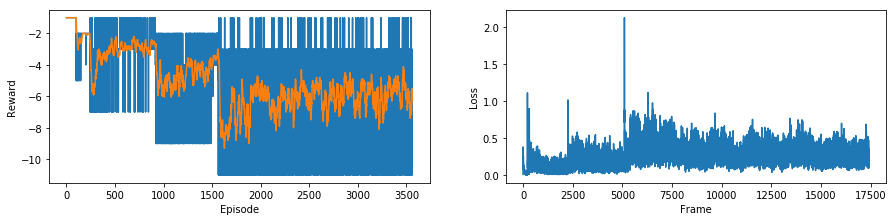

Percentage of success:  0.69













100%|██████████████████████████████████████| 1000/1000 [24:40<00:00,  1.48s/it]












Complete


In [143]:
for i in tqdm(range(1000)):
    agent.play()
    plot_durations(agent, 20)
    
    res = (np.array(agent.rewards_log[-100:]) > -11).mean()
    print("Percentage of success: ", res)
    if i > 100 and res > 0.95:
        break

print('Complete')
plt.show()

добивал до 0.75... Удалось повторить на nsteps = 2 при увеличинии learning_rate до 0.0035

# Безконтрольное обучение...

0.8 на пятом уровне даёт 0.7 на шестом, 0.5 на седьмом, и дальше всё, деградация.

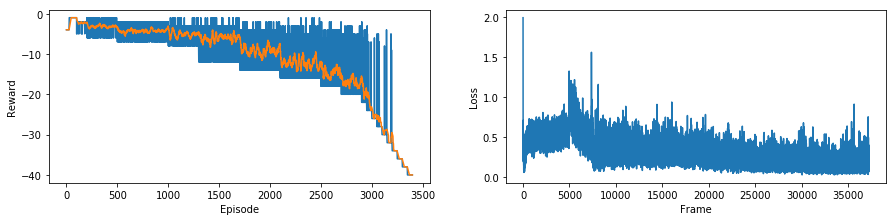











100%|██████████████████████████████████████████| 50/50 [10:10<00:00, 12.22s/it]











Complete


In [236]:
for level in range(10, 20):
    rubik.complexity, rubik.limit = level, 2*level+1
    
    for i in tqdm(range(50)):
        agent.play()
        plot_durations(agent, 20)
        
print('Complete')
plt.show()

In [234]:
print((np.array(agent.rewards_log[2500:2600]) > -18).mean())
print((np.array(agent.rewards_log[2600:2700]) > -18).mean())
print((np.array(agent.rewards_log[2700:2800]) > -20).mean())
print((np.array(agent.rewards_log[2800:2900]) > -20).mean())

0.24
0.29
0.2
0.22


In [237]:
agent.rewards_log[3000:]

[-26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -6,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -26,
 -28,
 -28,
 -5,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -5,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -7,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -28,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -8,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -30,
 -4,
 -30,
 -30,
 -30,
 -30,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32,
 -32

In [245]:
rubik.complexity, rubik.limit = 10, 100

In [246]:
agent.play(learn=False)

-101

# Динамическое изменение уровней

In [85]:
def plot_with_levels(agent, levels, means_window=100):
    """plot agent logs"""    
    clear_output(wait=True)
    
    plt.figure(2, figsize=(15, 7))
    plt.title('Training...')
    
    plt.subplot(221)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(agent.rewards_log)
    plt.plot(sliding_average(agent.rewards_log, means_window))
    
    if hasattr(agent, 'loss_log'):
        plt.subplot(222)
        plt.xlabel('Frame')
        plt.ylabel('Loss')
        plt.plot(agent.loss_log)
        
    if hasattr(agent, 'magnitude_log'):
        plt.subplot(223)
        plt.xlabel('Frame')
        plt.ylabel('Noise Average Magnitude')
        plt.plot(agent.magnitude_log)
        
    plt.subplot(224)
    plt.xlabel('Episode')
    plt.ylabel('Level')
    plt.plot(levels)
    
    plt.show()

In [65]:
levels = []
level = 1
checkpoint = 0

In [68]:
from tqdm import tqdm
for i in tqdm(range(1000)):
    rubik.complexity, rubik.limit = level, 2*level+1
    levels.append(level)
    
    agent.play()
    plot_with_levels(agent, levels, 20)
    
    if len(agent.rewards_log[checkpoint:]) > 30:
        if (np.array(agent.rewards_log[checkpoint:][-100:]) >= -2*level - 1).mean() > 0.55:
            level += 1
            checkpoint = len(agent.rewards_log)
        if level > 1 and (np.array(agent.rewards_log[checkpoint:][-100:]) >= -2*level - 1).mean() < 0.45:
            level -= 1
            checkpoint = len(agent.rewards_log)

print('Complete')
plt.show()

KeyboardInterrupt: 